# Shifting of Price Forwad Curves (PFCs) for Energy Markets

Toy model for the spot price for electricity:
$$
S(t) = S_0 + 
    \begin{cases}
    0 & ,0 \leq h(t) < 8\\
    P_p & ,8 \leq h(t) < 11\\
    -P_{pv} & ,11\leq h(t) < 16\\
    P_p & ,16 \leq h(t) \leq 20\\
    0 & ,20 < h(t) \leq 23
    \end{cases} +
    \begin{cases}
        0 & ,1\leq d(d) \leq 5\\
        -P_{we} & ,6\leq d(t) \leq 7
    \end{cases} +
    \begin{cases}
        0 & ,m(t) \in \{4,5,6,7,8,9\}\\
        P_{W} & ,m(t) \in \{1,2,3,10,11,12\}
    \end{cases} + \varepsilon
$$
The parameters here are:
$$
\begin{align*}
S_0 &\quad\text{Spot price level}\\
P_p & \quad\text{Peak price level}\\
P_{pv} & \quad\text{Price level with regard to solar power}\\
P_{we} & \quad\text{Price level for weekends}\\
P_W & \quad\text{Price level for winter}\\
h(t) & \quad\text{Hour of the time step $t$}\\
d(t) & \quad\text{Week day of the time step $t$}\\
m(t) & \quad\text{Month of the time step $t$}\\
\varepsilon&  \sim \mathcal{N}(\mu, \sigma^2)
\end{align*}
$$

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from rivapy.instruments.energy_futures_specifications import EnergyFutureSpecifications
from rivapy.tools.scheduler import SimpleSchedule
from rivapy.marketdata.pfc_shifter import PFCShifter


In [2]:
np.random.seed(42)
def spot_price_model(timestamp: dt.datetime, spot_price_level: float, peak_price_level:float, solar_price_level: float,
                     weekend_price_level:float, winter_price_level: float, epsilon_mean: float = 0, epsilon_var:float = 1):
                    spot_price = spot_price_level
                    if (timestamp.hour >= 8 and timestamp.hour < 11) or (timestamp.hour >= 16 and timestamp.hour <= 20):
                            spot_price += peak_price_level
                    elif timestamp.hour >= 11 and timestamp.hour < 16:
                            spot_price -= solar_price_level
                    
                    if timestamp.weekday() >= 5:
                            spot_price -= weekend_price_level

                    if timestamp.month in {1,2,3,10,11,12}:
                            spot_price += winter_price_level 

                    spot_price += np.random.normal(loc=epsilon_mean, scale=np.sqrt(epsilon_var))
                    return spot_price

In [3]:
parameter_dict = {
    'spot_price_level': 100,
    'peak_price_level': 10,
    'solar_price_level': 8,
    'weekend_price_level': 10,
    'winter_price_level': 20,
    'epsilon_mean': 0,
    'epsilon_var': 5
}


In [4]:
date_range = pd.date_range(start='1/1/2020', end='1/1/2022', freq='H', inclusive='left')

In [5]:
spot_prices = list(map(lambda x: spot_price_model(x, **parameter_dict), date_range))

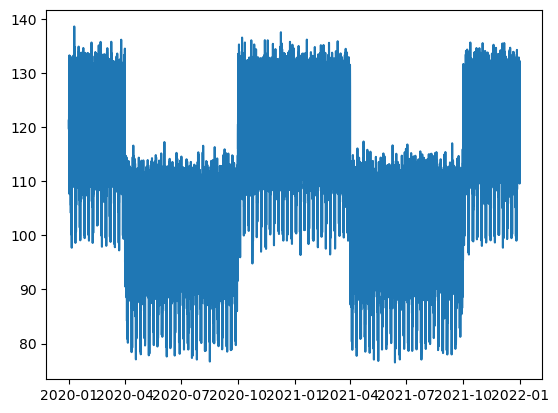

In [6]:
plt.plot(date_range, spot_prices)

In [7]:
# compute the shape 
df = pd.DataFrame(data=spot_prices, index=date_range, columns=['Spot'])
df

,Spot
2020-01-01 00:00:00,121.110687
2020-01-01 01:00:00,119.690832
2020-01-01 02:00:00,121.448276
2020-01-01 03:00:00,123.405598
2020-01-01 04:00:00,119.476417
...,...
2021-12-31 19:00:00,129.120348
2021-12-31 20:00:00,132.005100
2021-12-31 21:00:00,118.503252
2021-12-31 22:00:00,123.916270


In [8]:
base_y = df.resample('Y').mean()
base_y.index = base_y.index.strftime('%Y')

In [9]:
df_spot = df.copy()
df_spot.index = df_spot.index.strftime('%Y')
df_spot

,Spot
2020,121.110687
2020,119.690832
2020,121.448276
2020,123.405598
2020,119.476417
...,...
2021,129.120348
2021,132.005100
2021,118.503252
2021,123.916270


In [10]:
shape = df_spot.divide(base_y, axis='index')
shape_df = pd.DataFrame(data=shape['Spot'].tolist(), index=date_range, columns=['shape'])
shape_df

,shape
2020-01-01 00:00:00,1.112895
2020-01-01 01:00:00,1.099848
2020-01-01 02:00:00,1.115998
2020-01-01 03:00:00,1.133984
2020-01-01 04:00:00,1.097878
...,...
2021-12-31 19:00:00,1.186646
2021-12-31 20:00:00,1.213157
2021-12-31 21:00:00,1.089072
2021-12-31 22:00:00,1.138819


<AxesSubplot: >

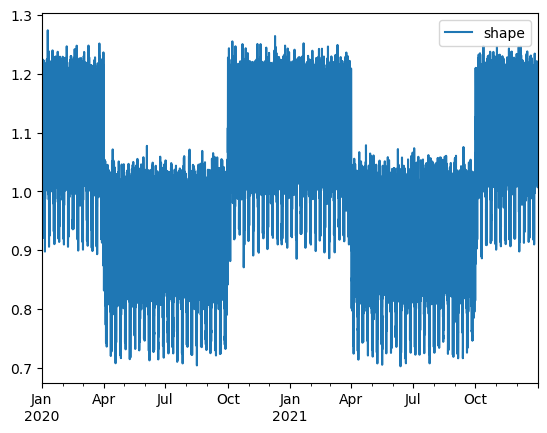

In [11]:
shape_df.plot()

In [38]:
contracts_schedules = {
    'Cal20_Base': SimpleSchedule(dt.datetime(2020,1,1), dt.datetime(2021,1,1), freq='1H'),
    # 'Cal20_Peak': SimpleSchedule(dt.datetime(2020,1,1), dt.datetime(2021,1,1), freq='1H', hours=set(np.arange(8,21))),
    # 'Cal20_OffPeak': SimpleSchedule(dt.datetime(2020,1,1), dt.datetime(2021,1,1), freq='1H', hours=set(np.arange(0,24))-set(np.arange(8,21))),
    'Cal21_Base': SimpleSchedule(dt.datetime(2021,1,1), dt.datetime(2022,1,1), freq='1H'),
    'Q1/20_Base': SimpleSchedule(dt.datetime(2020,1,1), dt.datetime(2020,4,1), freq='1H'),
    'Q2/20_Base': SimpleSchedule(dt.datetime(2020,4,1), dt.datetime(2020,7,1), freq='1H'),
    'Q3/20_Base': SimpleSchedule(dt.datetime(2020,7,1), dt.datetime(2020,10,1), freq='1H'),
    # 'Cal21_Peak': SimpleSchedule(dt.datetime(2021,1,1), dt.datetime(2022,1,1), freq='1H', hours=set(np.arange(8,21))),
    # 'Cal21_OffPeak': SimpleSchedule(dt.datetime(2021,1,1), dt.datetime(2022,1,1), freq='1H', hours=set(np.arange(0,24))-set(np.arange(8,21)))
}

In [39]:
test = SimpleSchedule(dt.datetime(2020,4,1), dt.datetime(2020,7,1), freq='1H')
test2 = SimpleSchedule(dt.datetime(2021,1,1), dt.datetime(2022,1,1), freq='1H', hours=set(np.arange(8,21)))

In [40]:
pd.infer_freq(test2.get_schedule()) 

In [41]:
contracts = {}
for contract_name, schedule in contracts_schedules.items():
    tg = schedule.get_schedule()
    price = df.loc[tg,:].mean()[0]
    contracts[contract_name] = EnergyFutureSpecifications(schedule=schedule, price=price, name=contract_name)

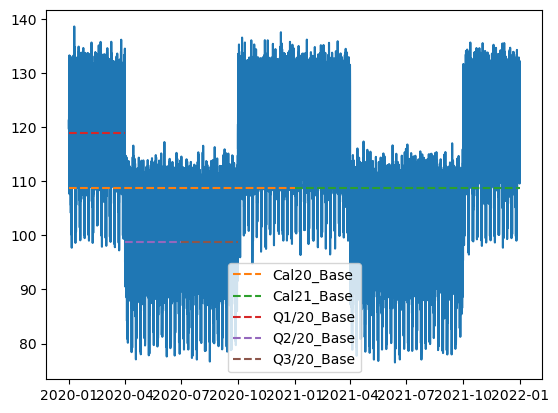

In [42]:

plt.plot(date_range, spot_prices)
ax = plt.gca()
for name, contract in contracts.items():
    y_value = contract.price  # The y-coordinate for the horizontal line
    x_range = contract.schedule.get_schedule()  # List of datetime values
    
    # Extract the minimum and maximum dates from the x_range
    xmin = min(x_range)
    xmax = max(x_range)
    
    # Plot a horizontal line for the contract
    color = next(ax._get_lines.prop_cycler)['color']
    plt.hlines(y=y_value, xmin=xmin, xmax=xmax, linestyle='--', label=name, colors=color)

plt.legend()
plt.show()

In [43]:
pfc_shifter = PFCShifter(shape=shape_df, contracts=contracts)

In [44]:
pfc_shifter

In [45]:
pfc_shifter.shape

,shape
2020-01-01 00:00:00,1.112895
2020-01-01 01:00:00,1.099848
2020-01-01 02:00:00,1.115998
2020-01-01 03:00:00,1.133984
2020-01-01 04:00:00,1.097878
...,...
2021-12-31 19:00:00,1.186646
2021-12-31 20:00:00,1.213157
2021-12-31 21:00:00,1.089072
2021-12-31 22:00:00,1.138819


In [46]:
pfc_shifter._get_contract_start_end_dates()

[datetime.datetime(2020, 1, 1, 0, 0),
 datetime.datetime(2020, 4, 1, 0, 0),
 datetime.datetime(2020, 7, 1, 0, 0),
 datetime.datetime(2020, 10, 1, 0, 0),
 datetime.datetime(2021, 1, 1, 0, 0),
 datetime.datetime(2022, 1, 1, 0, 0)]

In [66]:
transition_matrix=pfc_shifter.generate_transition_matrix()
transition_matrix

,2020-01-01,2020-04-01,2020-07-01,2020-10-01,2021-01-01
Cal20_Base,1.0,1.0,1.0,1.0,0.0
Cal21_Base,0.0,0.0,0.0,0.0,1.0
Q1/20_Base,1.0,0.0,0.0,0.0,0.0
Q2/20_Base,0.0,1.0,0.0,0.0,0.0
Q3/20_Base,0.0,0.0,1.0,0.0,0.0


In [67]:
transition_matrix = pfc_shifter.detect_redundant_contracts(transition_matrix=transition_matrix)
transition_matrix

,2020-01-01,2020-04-01,2020-07-01,2020-10-01,2021-01-01
Cal20_Base,1.0,1.0,1.0,1.0,0.0
Cal21_Base,0.0,0.0,0.0,0.0,1.0
Q1/20_Base,1.0,0.0,0.0,0.0,0.0
Q2/20_Base,0.0,1.0,0.0,0.0,0.0
Q3/20_Base,0.0,0.0,1.0,0.0,0.0


In [68]:
np.linalg.inv(transition_matrix.to_numpy())

array([[ 0.,  0.,  1.,  0.,  0.],
       [-0., -0., -0.,  1., -0.],
       [-0., -0., -0., -0.,  1.],
       [ 1., -0., -1., -1., -1.],
       [ 0.,  1.,  0.,  0.,  0.]])

In [69]:
shifted = pfc_shifter.shift(transition_matrix)
shifted

,shape
2020-01-01 00:00:00,121.110687
2020-01-01 01:00:00,119.690832
2020-01-01 02:00:00,121.448276
2020-01-01 03:00:00,123.405598
2020-01-01 04:00:00,119.476417
...,...
2021-12-31 19:00:00,129.120348
2021-12-31 20:00:00,132.005100
2021-12-31 21:00:00,118.503252
2021-12-31 22:00:00,123.916270


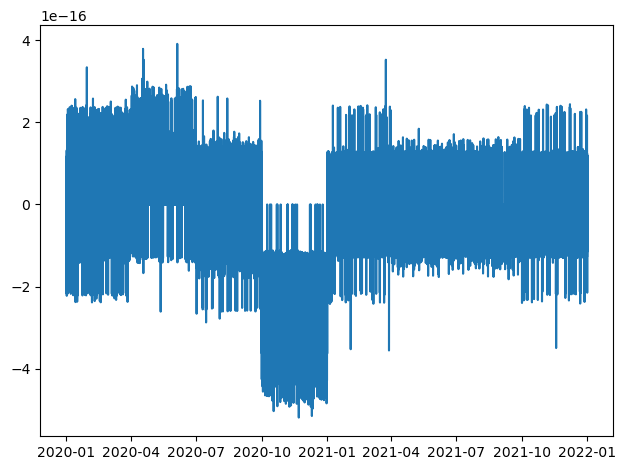

In [70]:
# relative error
rel_err = (spot_prices-shifted.iloc[:,0])/spot_prices
plt.plot(rel_err)
plt.tight_layout()

# Synthetic Contracts

In [132]:
contracts_schedules_synthetic = {
    'Cal20_Base': SimpleSchedule(dt.datetime(2020,1,1), dt.datetime(2021,1,1), freq='1H'),
    'Cal21_Base': SimpleSchedule(dt.datetime(2021,1,1), dt.datetime(2022,1,1), freq='1H'),
    'Q1/20_Base': SimpleSchedule(dt.datetime(2020,1,1), dt.datetime(2020,4,1), freq='1H'),
    'Q2/20_Base': SimpleSchedule(dt.datetime(2020,4,1), dt.datetime(2020,7,1), freq='1H'),
    'Q3/20_Base': SimpleSchedule(dt.datetime(2020,7,1), dt.datetime(2020,10,1), freq='1H'),
    'Q4/20_Base': SimpleSchedule(dt.datetime(2020,10,1), dt.datetime(2021,1,1), freq='1H'),
    'M1/20_Base': SimpleSchedule(dt.datetime(2020,1,1), dt.datetime(2020,2,1), freq='1H'),
    'Sum/21_Base': SimpleSchedule(dt.datetime(2021,4,1), dt.datetime(2021,10,1), freq='1H')
    
}

In [133]:
contracts_synth = {}
for contract_name, schedule in contracts_schedules_synthetic.items():
    tg = schedule.get_schedule()
    price = df.loc[tg,:].mean()[0]
    contracts_synth[contract_name] = EnergyFutureSpecifications(schedule=schedule, price=price, name=contract_name)

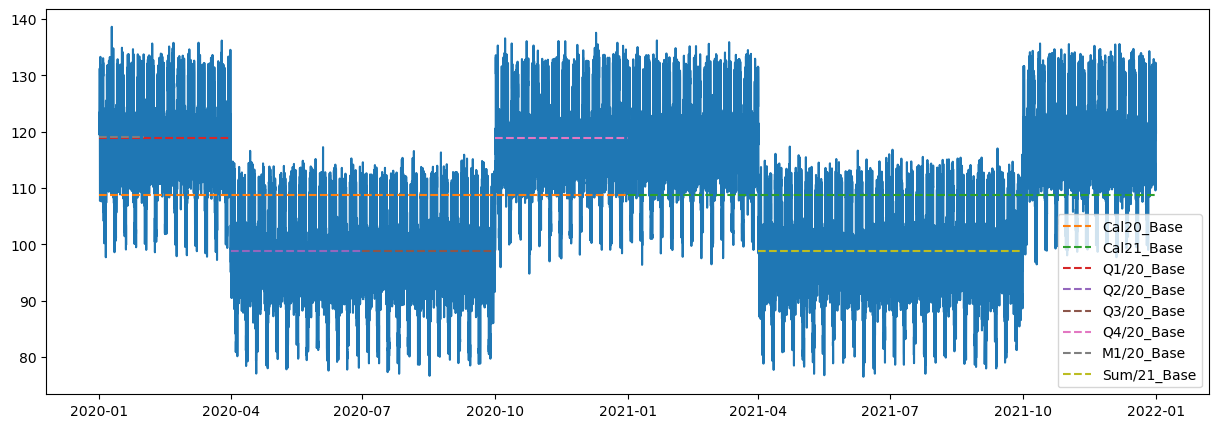

In [134]:
plt.figure(figsize=(15,5))
plt.plot(date_range, spot_prices)
ax = plt.gca()
for name, contract in contracts_synth.items():
    y_value = contract.price  # The y-coordinate for the horizontal line
    x_range = contract.schedule.get_schedule()  # List of datetime values
    
    # Extract the minimum and maximum dates from the x_range
    xmin = min(x_range)
    xmax = max(x_range)
    
    # Plot a horizontal line for the contract
    color = next(ax._get_lines.prop_cycler)['color']
    plt.hlines(y=y_value, xmin=xmin, xmax=xmax, linestyle='--', label=name, colors=color)

plt.legend()
plt.show()

In [135]:
pfc_shifter_synth = PFCShifter(shape=shape_df, contracts=contracts_synth)

In [136]:
transition_matrix_synth=pfc_shifter_synth.generate_transition_matrix()
transition_matrix_synth

,2020-01-01,2020-02-01,2020-04-01,2020-07-01,2020-10-01,2021-01-01,2021-04-01,2021-10-01
Cal20_Base,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
Cal21_Base,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
Q1/20_Base,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Q2/20_Base,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Q3/20_Base,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
Q4/20_Base,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
M1/20_Base,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sum/21_Base,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [131]:
transition_matrix_synth = pfc_shifter_synth.detect_redundant_contracts(transition_matrix=transition_matrix_synth)
transition_matrix_synth

Found redundant contract: Cal20_Base2
Found redundant contract: Q4/20_Base


,2020-01-01,2020-02-01,2020-04-01,2020-07-01,2020-10-01,2021-01-01,2021-04-01,2021-10-01
Cal20_Base,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
Cal21_Base,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
Q1/20_Base,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Q2/20_Base,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Q3/20_Base,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
M1/20_Base,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sum/21_Base,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [73]:
# since we found a redundant contract the new transitions matrix is not quadratic anymore
transition_matrix_synth.shape

(7, 8)

In [74]:
transition_matrix_synth.iloc[:, -3] == transition_matrix_synth.iloc[:, -1]

Cal20_Base     True
Cal21_Base     True
Q1/20_Base     True
Q2/20_Base     True
Q3/20_Base     True
M1/20_Base     True
Sum/21_Base    True
dtype: bool

In [75]:
transition_matrix_synth.sum(axis=0)

2020-01-01    3.0
2020-02-01    2.0
2020-04-01    2.0
2020-07-01    2.0
2020-10-01    1.0
2021-01-01    1.0
2021-04-01    2.0
2021-10-01    1.0
dtype: float64

In [84]:
test = np.linalg.qr(transition_matrix_synth.T.to_numpy())

In [87]:
test[-1]

array([[-2.23606798e+00,  0.00000000e+00, -8.94427191e-01,
        -4.47213595e-01, -4.47213595e-01, -4.47213595e-01,
         0.00000000e+00],
       [ 0.00000000e+00, -1.73205081e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -5.77350269e-01],
       [ 0.00000000e+00,  0.00000000e+00,  1.09544512e+00,
        -3.65148372e-01, -3.65148372e-01,  5.47722558e-01,
         4.25882649e-17],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         8.16496581e-01, -4.08248290e-01, -2.22044605e-16,
         3.08778804e-18],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  7.07106781e-01, -1.73472348e-16,
         3.10008897e-18],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -7.07106781e-01,
         1.11022302e-16],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -8.1649658

In [143]:
def max_rank(matrix, rows_left, i, mask, memo):
    # Base case: if no more rows left to append, return rank of the current matrix
    if rows_left == 0:
        return np.linalg.matrix_rank(matrix), matrix

    # Check if the result for this state has already been computed
    if (i, mask) in memo:
        return memo[(i, mask)]

    max_rank_value = -1
    best_matrix = None
    for next_i in range(matrix.shape[1]):
        # Check if the column has already been selected
        if (mask >> next_i) & 1 == 0:
            # Append a new row with 1 in the current column
            new_row = np.zeros((1, matrix.shape[1]))
            new_row[0, next_i] = 1
            new_matrix = np.vstack([matrix, new_row])
            # Update mask for the next recursion
            next_mask = mask | (1 << next_i)
            # Recursively compute the maximum rank for the next state
            rank, result_matrix = max_rank(new_matrix, rows_left - 1, next_i, next_mask, memo)
            if rank > max_rank_value:
                max_rank_value = rank
                best_matrix = result_matrix

    # Memoize the result
    memo[(i, mask)] = max_rank_value, best_matrix
    return max_rank_value, best_matrix

def find_best_columns(matrix, rows_to_append):
    memo = {}
    _, best_matrix = max_rank(matrix, rows_to_append, 0, 0, memo)
    return best_matrix

# Example usage
m = np.array([[1, 0, 1, 0],
              [1, 1, 1, 0]])
rows_to_append = 2
result = find_best_columns(m, rows_to_append)
print("Resulting matrix:")
print(result)

Resulting matrix:
[[1. 0. 1. 0.]
 [1. 1. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]]


In [106]:
result

array([[1., 0., 1., 0.],
       [1., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.]])

In [141]:

def is_linearly_independent(matrix):
    # Check linear independence using SVD
    _, s, _ = np.linalg.svd(matrix)
    # Tolerance for singular values
    tol = np.finfo(float).eps * max(matrix.shape)
    return np.all(s > tol)

def add_row(matrix, new_row):
    new_matrix = np.vstack([matrix, new_row])
    return new_matrix

def append_rows(matrix, n):
    m, _ = matrix.shape
    for _ in range(n):
        for col_index in range(matrix.shape[1]):
            # Append a new row with 1 in the current column
            new_row = np.zeros((1, matrix.shape[1]))
            new_row[0, col_index] = 1
            new_matrix = add_row(matrix, new_row)
            # Check if the new matrix remains linearly independent
            if is_linearly_independent(new_matrix):
                matrix = new_matrix
                break
    return matrix

# Example usage
m = np.array([[1, 0, 1, 0],
              [1, 1, 1, 0]])
result = append_rows(m, 2)  # Append 2 rows to make it square
print(result)

[[1. 0. 1. 0.]
 [1. 1. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]]


In [145]:


############## use this !!!!!#########################
def is_linearly_independent(matrix):
    # Check linear independence by comparing rank
    return np.linalg.matrix_rank(matrix) == matrix.shape[0]

def add_row(matrix, new_row):
    new_matrix = np.vstack([matrix, new_row])
    return new_matrix

def append_rows(matrix, n):
    m, _ = matrix.shape
    for _ in range(n):
        for col_index in range(matrix.shape[1]):
            # Append a new row with 1 in the current column
            new_row = np.zeros((1, matrix.shape[1]))
            new_row[0, col_index] = 1
            new_matrix = add_row(matrix, new_row)
            # Check if the new matrix remains linearly independent
            if is_linearly_independent(new_matrix):
                matrix = new_matrix
                break
    return matrix

# Example usage
m = np.array([[1, 0, 1, 0]])
result = append_rows(m, 3)  # Append 2 rows to make it square
print(result)

[[1. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]]
